In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

matplotlib.rcParams['font.family'] = 'Arial'

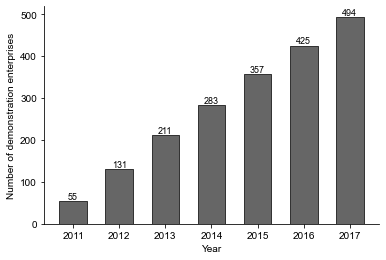

In [ ]:
# Accumulated number ofdemonstration enterprises by year (Figure 1)

de_data = pd.read_excel('./raw/示范企业认定数据/企业认定时间短面板.xlsx')
denum_year = pd.DataFrame({'year' : range(2012, 2019), 'denum' : [np.nan] * len(range(2012, 2019))})

for index, row in denum_year.iterrows():
    i_year = denum_year.loc[index, 'year']
    denum_year.loc[index, 'denum'] = de_data[i_year].sum()

## plotting
fig, ax = plt.subplots()
bars = ax.bar(denum_year['year'], denum_year['denum'], width=0.6, edgecolor=plt.cm.gray(0.2), color=plt.cm.gray(0.4))
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,  
        f'{height:.0f}',
        ha='center',  
        va='bottom',  
        fontsize=9  
    )

ax.set_xlabel('Year')
ax.set_ylabel('Number of demonstration enterprises')
ax.spines['top'].set_color('none')  
ax.spines['right'].set_color('none')
plt.xticks(range(2012, 2019, 1), range(2011, 2018, 1), size=10)

plt.show()
fig.savefig('./figures/pdf/demon_num_by_year.pdf', format='pdf', bbox_inches='tight')
fig.savefig('./figures/svg/demon_num_by_year.svg', format='svg', bbox_inches='tight')

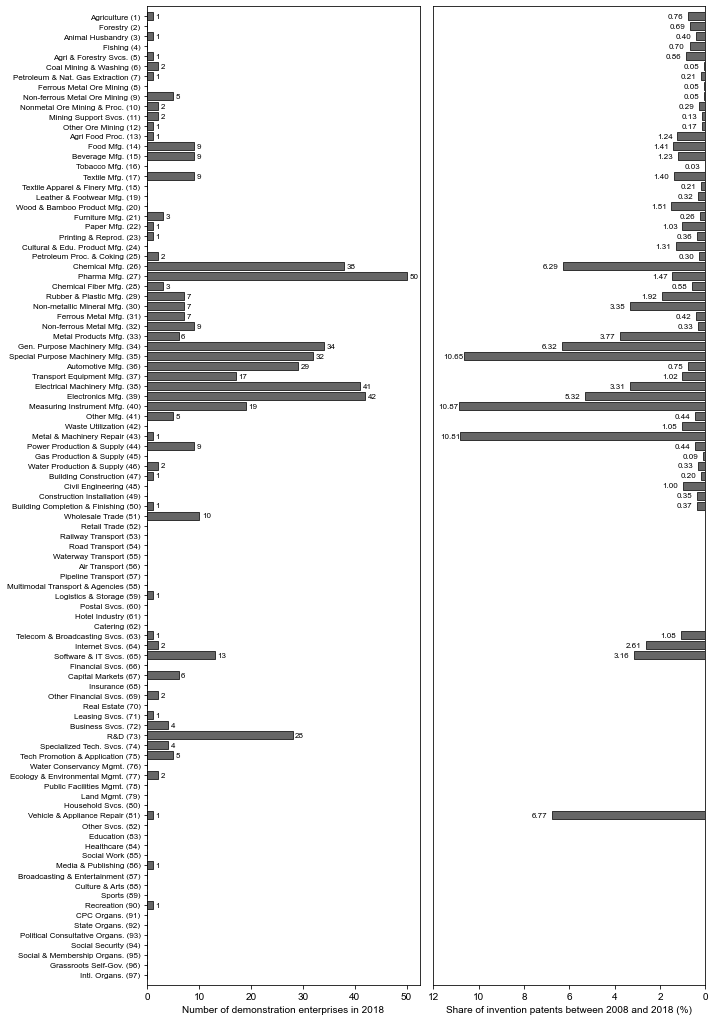

In [ ]:
# Number of demonstration enterprises and share of invention patents by industry (Figure A.4)

## number of demonstration enterprises
ind = pd.read_excel('./raw/其他数据/国民经济行业分类表.xlsx')
ind = ind.loc[:, ['行业大类代码', '行业大类名称']].drop_duplicates().reset_index(drop=True)
ind_dict = ind.set_index('行业大类名称').to_dict()['行业大类代码']
ind_name = pd.read_excel('./raw/其他数据/行业大类中英对应表.xlsx')
ind_name['缩写en'] = ind_name['缩写en'] + ' (' + ind_name['行业大类代码'].astype(str) + ')'
ind_name_dict = ind_name.set_index('行业大类代码')['缩写en'].to_dict()

de_data = pd.read_excel('./raw/示范企业认定数据/企业认定时间短面板.xlsx')
de_data = de_data[de_data[2018]==1]
de_data['ind'] = de_data['industry'].map(ind_dict)
ind['denum'] = ind['行业大类代码'].apply(lambda x : len(de_data[de_data['ind'] == x]))
ind['ind'] = ind['行业大类代码'].map(ind_name_dict)
ind = ind.sort_values(by='行业大类代码', ascending=False).reset_index(drop=True)

## number of patent applications
patent_data = pd.read_csv('./build/city_ind_panel.csv')
#patent_data = patent_data[(patent_data['year']>=2008) & (patent_data['year']<=2011)]
patent_data = patent_data[(patent_data['year']>=2008) & (patent_data['year']<=2018)]
patent_data = patent_data.groupby(['ind']).agg({'invention' : 'sum'}).reset_index()
patent_data['invention_share'] = patent_data['invention'] / patent_data['invention'].sum() * 100
patent_share_dict = patent_data.set_index('ind')['invention_share'].to_dict()

ind['invention_share'] = ind['行业大类代码'].map(patent_share_dict)
ind['invention_share'] = ind['invention_share'].fillna(0)

## plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 18))
bars0 = ax[0].barh(ind['ind'], ind['denum'], edgecolor=plt.cm.gray(0.2), color=plt.cm.gray(0.4))
ax[0].set_ylim(-1, len(ind['ind']))
ax[0].yaxis.set_tick_params(labelsize=8)
ax[0].set_xlabel('Number of demonstration enterprises in 2018')

bars1 = ax[1].barh(ind['ind'], -ind['invention_share'], edgecolor=plt.cm.gray(0.2), color=plt.cm.gray(0.4))
ax[1].set_ylim(-1, len(ind['ind']))
ax[1].set_xlim(-12, right=0) 
ax[1].set_xlabel('Share of invention patents between 2008 and 2018 (%)')

ax[1].set_yticklabels([])  
ax[1].tick_params(axis='y', left=False) 
ax[1].set_xticks(ax[1].get_xticks())  
ax[1].set_xticklabels([f"{abs(x):.0f}" for x in ax[1].get_xticks()])

for bar in bars0:
    width = bar.get_width() 
    text_value = f'{width:.0f}' if width != 0 else ''
    ax[0].text(width + 0.5, bar.get_y() + bar.get_height() / 2,  
            text_value,
            va='center',
            fontsize=8,
            color='black')

for bar in bars1:
    width = -bar.get_width()
    text_value = f'{width:.2f}' if width != 0 else ''
    ax[1].text(-width - 0.9, bar.get_y() + bar.get_height() / 2,
            text_value,
            va='center', 
            fontsize=8,
            color='black')

plt.subplots_adjust(wspace=0.05)
plt.show()
fig.savefig('./figures/pdf/demon_num_by_industry.pdf', format='pdf', bbox_inches='tight')
fig.savefig('./figures/svg/demon_num_by_industry.svg', format='svg', bbox_inches='tight')

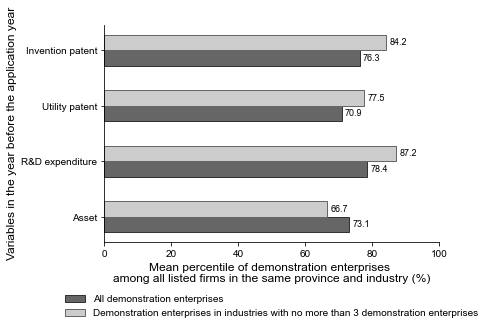

In [ ]:
# The percentile of demonstrations firms in the local market (Figure A.5)

listed = pd.read_csv('./build/listed_panel.csv')
listed = listed[(listed['year']>=2008) & (listed['year']<=2018)]
listed['rd_share'] = listed.apply(lambda row : row['rd'] / row['revenue'] if row['revenue'] > 0 else np.nan, axis=1)

## initialization
demon_firm = listed[listed['demon_firm']==1].loc[:, ['stock_code']]
demon_firm = demon_firm.drop_duplicates(subset=['stock_code']).reset_index(drop=True)
demon_firm['treated_year'] = demon_firm['stock_code'].apply(lambda x : 2019-listed[listed['stock_code']==x]['treated'].sum())
demon_firm['treated_year'] = demon_firm['treated_year'].astype(int)
demon_firm['granted_year'] = demon_firm['treated_year'] - 2 # use the year before application year for comparison
demon_firm = demon_firm[demon_firm['treated_year']<=2018].reset_index(drop=True) 

## match financial and patent indicators for demonstration enterprises
for index, row in demon_firm.iterrows():
    i_code = demon_firm.loc[index, 'stock_code']
    i_year = demon_firm.loc[index, 'granted_year']
    i_matched_data = listed[(listed['stock_code']==i_code) & (listed['year']==i_year)]

    if len(i_matched_data) == 1:
        demon_firm.loc[index, 'prov'] = i_matched_data['prov'].values[0]
        demon_firm.loc[index, 'city'] = i_matched_data['city'].values[0]
        demon_firm.loc[index, 'ind'] = i_matched_data['ind'].values[0]
        demon_firm.loc[index, 'registered_capital'] = i_matched_data['registered_capital'].values[0]
        demon_firm.loc[index, 'invention'] = i_matched_data['invention'].values[0]
        demon_firm.loc[index, 'utility'] = i_matched_data['utility'].values[0]
        demon_firm.loc[index, 'asset'] = i_matched_data['asset'].values[0]
        demon_firm.loc[index, 'rd'] = i_matched_data['rd'].values[0]

## calculate the financial and patent indicators for other listed firms
for index, row in demon_firm.iterrows():
    i_stock_code = demon_firm.loc[index, 'stock_code']
    i_year = demon_firm.loc[index, 'granted_year']
    i_prov = demon_firm.loc[index, 'prov']
    i_city = demon_firm.loc[index, 'city']
    i_ind = demon_firm.loc[index, 'ind']
    i_registered_capital = demon_firm.loc[index, 'registered_capital']
    i_invention = demon_firm.loc[index, 'invention']
    i_utility = demon_firm.loc[index, 'utility']
    i_asset = demon_firm.loc[index, 'asset']
    i_rd = demon_firm.loc[index, 'rd']
    i_matched_data = listed[
                            (listed['year'] == i_year) & 
                            (listed['prov'] == i_prov) & 
                            (listed['ind'] == i_ind) & 
                            (listed['stock_code'] != i_stock_code)
                            ]
    demon_firm.loc[index, 'others_num'] = len(i_matched_data)
    
    if len(i_matched_data) > 0:
        demon_firm.loc[index, 'invention_percentile'] = percentileofscore(i_matched_data['invention'].fillna(0), i_invention, kind='weak')
        demon_firm.loc[index, 'utility_percentile'] = percentileofscore(i_matched_data['utility'].fillna(0), i_utility, kind='weak')
        demon_firm.loc[index, 'asset_percentile'] = percentileofscore(i_matched_data['asset'].fillna(0), i_asset, kind='weak')
        demon_firm.loc[index, 'rd_percentile'] = percentileofscore(i_matched_data['rd'].fillna(0), i_rd, kind='weak')

percentile = [
                demon_firm['asset_percentile'].mean(), 
                demon_firm['rd_percentile'].mean(),
                demon_firm['utility_percentile'].mean(),
                demon_firm['invention_percentile'].mean()
            ]

## list of industries with more than 3 listed demonstration enterprises
num_by_ind = demon_firm['ind'].value_counts()
ind_list_3 = list(num_by_ind[num_by_ind<=3].index)
demon_limited = demon_firm[demon_firm['ind'].isin(ind_list_3)]

## calculate the average percentile
percentile_limited = [
                demon_limited['asset_percentile'].mean(), 
                demon_limited['rd_percentile'].mean(),
                demon_limited['utility_percentile'].mean(),
                demon_limited['invention_percentile'].mean() 
            ]

percentile_data = pd.DataFrame({'var' : ['Asset', 'R&D expenditure', 'Utility patent', 'Invention patent',], 
                                'percentile' : percentile, 
                                'percentile_5' : percentile_limited}
                                )

## plotting
y = range(len(percentile_data))
bar_height = 0.28

fig, ax = plt.subplots()
bars0 = ax.barh([yi - bar_height/2 for yi in y], percentile_data['percentile'], 
        height=bar_height, edgecolor=plt.cm.gray(0.2), color=plt.cm.gray(0.4), 
        label='All demonstration enterprises')
bars1 = ax.barh([yi + bar_height/2 for yi in y], percentile_data['percentile_5'], 
        height=bar_height, edgecolor=plt.cm.gray(0.4), color=plt.cm.gray(0.8), 
        label='Demonstration enterprises in industries with no more than 3 demonstration enterprises')

ax.set_xlabel('Mean percentile of demonstration enterprises \namong all listed firms in the same province and industry (%)', fontsize=12)
ax.set_xlim(0, 100)
ax.set_yticks(y)
ax.set_yticklabels(percentile_data['var'])
ax.set_ylabel('Variables in the year before the application year', fontsize=12)

for bar in bars0 + bars1:
    width = bar.get_width()  
    text_value = f'{width:.1f}' if width != 0 else ''
    ax.text(width + 1, bar.get_y() + bar.get_height() / 2, 
            text_value,
            va='center',
            fontsize=9,
            color='black')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none') 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1, frameon=False)

plt.show()
fig.savefig('./figures/pdf/demon_prcentile.pdf', format='pdf', bbox_inches='tight')
fig.savefig('./figures/svg/demon_percentile.svg', format='svg', bbox_inches='tight')